# Pycaret Time Series Candidate Darts 

___

## Contents 

1. [Intro](#darts_intro)

2. [Installation](#darts_installation)

3. [Data](#darts_data)

    * [Split Data (Train/Test)](#darts_data_split)
    
    * **Time Series Diagnosis**
    
        * [Auto Correlation Plot](#darts_acf)
    
        * [Seasonal period](#darts_check_seasonality)
    
        * [Trend and Seasonal Component](#darts_extract_trend_seasonality)
    
        * [Remove Trend and Seasonal Component](#darts_remove_trend_seasonality)
    
4. [Models](#darts_models)

    * **Univariate Models**

        * [Fast Fourier Transform](#darts_fft)
    
        * [Recurrent Neural Networks](#darts_rnn)
        
    * **Ensemble Models**
        * [EnsembleModel Class](#darts_ensemble_model)
    
5. Utilities

    * [Scalers](#darts_scaler)
    
    * [Transforms](#darts_transforms)
    
    * [Fill Missing Values](#darts_missing_values)
    
    * [Pipeline (Apply several transformers)](#darts_pipeline)
    
6. Evaluation

    * [BackTesting](#darts_backtesting)
    
    * [Residual Analysis](#darts_residual_analysis)
    
7. Tuning

    * [GridSearch](#darts_gridsearch)
    
8. [Conclusion](#darts_conclusion)
___

## <a name="darts_intro">Darts Intro</a>

From the [docs](https://unit8co.github.io/darts/) 


>Darts is a python library for **easy manipulation and forecasting of time serie**. It contains a variety of models, from **classics such as ARIMA to neural networks**. The models can **all be used in the same way**, using **fit() and predict() functions**, similar to scikit-learn. The library also makes it easy to backtest models, and combine the predictions of several models and external regressors. Darts supports both univariate and multivariate time series and models.

**References**:

* **API Functionality:** https://unit8co.github.io/darts/generated_api/darts.html

* **Repo:** https://github.com/unit8co/darts

___

## <a name="darts_installation">Installation</a>

Better to only install `core` dependencies

```txt 
numpy==1.19.0
scipy==1.5.0
statsmodels==0.11.1 (*)
matplotlib==3.2.2
pandas==1.1.0
ipython==7.15.0
tqdm==4.46.1 (*)
holidays==0.10.2 (*)
scikit-learn==0.23.2
```
with
```bash
pip install u8darts -q
```
[pmdarima](https://github.com/unit8co/darts/blob/master/requirements/pmdarima.txt) (__*__), [torch](https://github.com/unit8co/darts/blob/master/requirements/torch.txt) (__*__) (torch is 753.2 MB, not sure why it requires tensorboard) and [prophet](https://github.com/unit8co/darts/blob/master/requirements/fbprophet.txt) (__*__) require additional installation. 

One could also install all deps with
```bash
pip install 'u8darts[all]' -q
```

> **Note**. * indicate that it will be required to be installed as dependency for pycaret

___

**Darts Installed Package Size**

| Module | Version | Size |
|--------| ------| ------- |
| torch  | 1.5.1      |  1.4GB|
| tensorboard |  2.2.2      |   9.9MB |  
| statsmodels | 0.11.1 | 43MB   |
| tqdm | 4.46.1 | 360K     |
| holidays | 0.10.2 | 756K   |
| pmdarima | 1.6.1   | 5.3MB   |
| fbprohphet | 0.6   | 31MB   |

Module size was verified with the command

```bash
pip list | tail -n +3 | awk '{print $1}' | xargs pip show | grep -E 'Location:|Name:' | cut -d ' ' -f 2 | paste -d ' ' - - | awk '{print $2 "/" tolower($1)}' | xargs du -sh 2> /dev/null | sort -hr
```

___

## <a name="darts_data">3. Data</a>

The `AirPassengers` dataset is used as example, downloaded from [here](https://raw.githubusercontent.com/unit8co/darts/master/examples/AirPassengers.csv) (Sktime has `load_airline` func)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

# Load dataseet
df = pd.read_csv('AirPassengers.csv', delimiter=",")

# A TimeSeries is an object representing a univariate or multivariate time series.
# Ref: https://github.com/unit8co/darts/blob/master/darts/timeseries.py#L523
series_from_dataframe = TimeSeries.from_dataframe(df, 'Month', '#Passengers') # all are static methods

# Ref: https://github.com/unit8co/darts/blob/master/darts/timeseries.py#L499
# There is an issue with this method. Bug: https://github.com/unit8co/darts/issues/253
#series_from_series = TimeSeries.from_series(df['#Passengers'], freq='Month', fill_missing_dates=True)

# Ref: https://github.com/unit8co/darts/blob/master/darts/timeseries.py#L569
series_from_index_values = TimeSeries.from_times_and_values(times=pd.DatetimeIndex(df.Month), values=df['#Passengers'].to_list())

### <a name="darts_data_split">3.1 Splitting Data</a>

**Source Code**: [link](https://github.com/unit8co/darts/blob/master/darts/timeseries.py#L257)

Compare to `sktime.forecasting.model_selection.temporal_train_test_split` that splits data with size, darts splits data given a timestamp.

In [3]:
# Split takes as input a timestamp
# Split a period after the specified date, i.e. val data starts on 1958-02-01
train, val = series_from_dataframe.split_after(pd.Timestamp('19580101'))

# Split on the period specified, i.e. val data starts on 1958-01-01
train, val = series_from_dataframe.split_before(pd.Timestamp('19580101'))

### <a name="darts_acf">3.2 Auto Correlation Plot</a>

The `darts.utils.statistics` module offers functionality to diagnosis a time series, including autocorrelation plot (`plot_acf`), seasonality period (`check_seasonality`), decomposing it into seasonal and trend component (`extract_trend_and_seasonality`) and extract these components (`remove_trend` and `remove_seasonality`)

**Source Code:** [link](https://github.com/unit8co/darts/blob/master/darts/utils/statistics.py#L257)

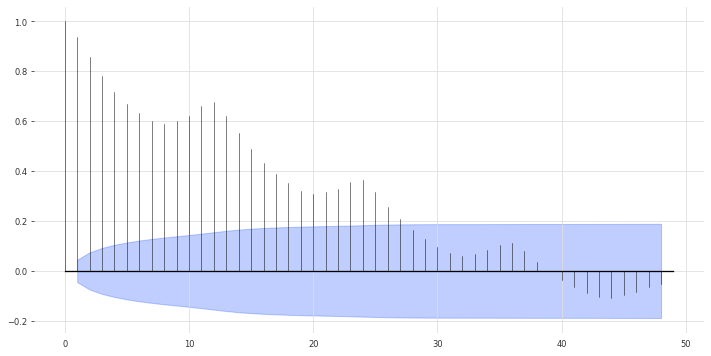

In [4]:
from darts.utils.statistics import plot_acf

plot_acf(train, max_lag=48, alpha = .05, fig_size=(12, 6))

### <a name="darts_check_seasonality">3.3 Check Seasonality</a>

**Source Code:** [link](https://github.com/unit8co/darts/blob/master/darts/utils/statistics.py#L24)

In [5]:
# Taken from: https://github.com/unit8co/darts/blob/master/examples/darts-intro.ipynb
from darts.utils.statistics import check_seasonality

for m in range(2, 24):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05, max_lag=36)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 12.


### <a name="darts_extract_trend_seasonality">3.4 Seasonal and Trend Component</a>

**Source Code**: [link](https://github.com/unit8co/darts/blob/master/darts/utils/statistics.py#L125)

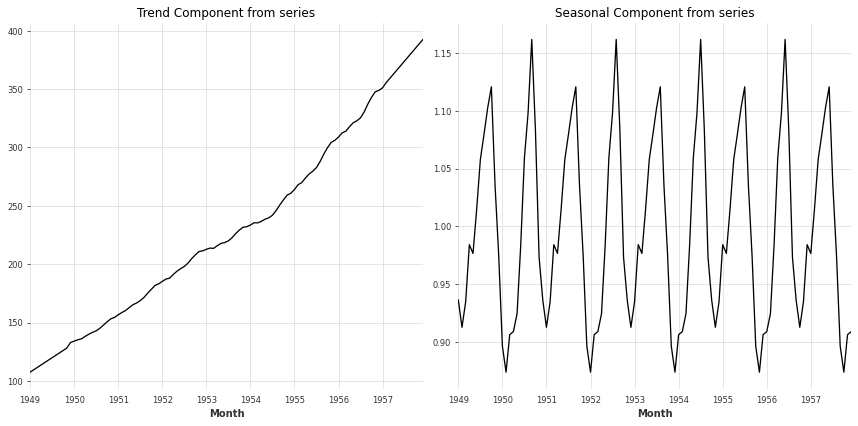

In [6]:
from darts.utils.statistics import extract_trend_and_seasonality

series_trend, series_season = extract_trend_and_seasonality(train, freq=period)

# Set figsize
plt.figure(figsize=(12, 6))

# Left side figure
plt.subplot(1, 2, 1)
series_trend.plot()
plt.title('Trend Component from series')

# Right side figure
plt.subplot(1, 2, 2)
series_season.plot()
plt.title('Seasonal Component from series')

# Set space between plots
plt.tight_layout(1)

### <a name="darts_remove_trend_seasonality">3.5 Remove Trend and Seasonality</a>

**Source Code:** [link](https://github.com/unit8co/darts/blob/master/darts/utils/statistics.py#L199)

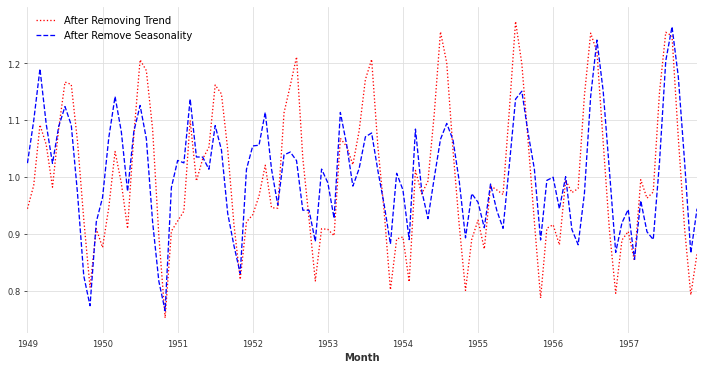

In [7]:
from darts.utils.statistics import (remove_trend, remove_seasonality)

# Remove trend
train_detrend = remove_trend(train)

# Remove seasonality
train_deseasonalized = remove_seasonality(train_detrend, freq=period)

plt.figure(figsize=(12, 6))

# Detrended series
train_detrend.plot(label='After Removing Trend', color='red', linestyle='dotted')

# Deseasonalized series
train_deseasonalized.plot(label='After Remove Seasonality', color='blue', linestyle='--')

plt.legend()

## <a name="darts_models">4. Models</a>

All models follow a `fit` and `predict` functionality as sklearn. As all the models have this functionality we only test the Fast Fourier Transformand and an RNN model.

### <a name="darts_fft">4.1 Fast Fourier Transform</a>

**Source Code**: [link](https://github.com/unit8co/darts/blob/master/darts/models/fft.py#L195) 

Due to the nature of the Fourier series (sines and cosines) this model is ideal for seasonal data.

Importing plotly failed. Interactive plots will not work.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


FFT MAPE: 12.654527052802775


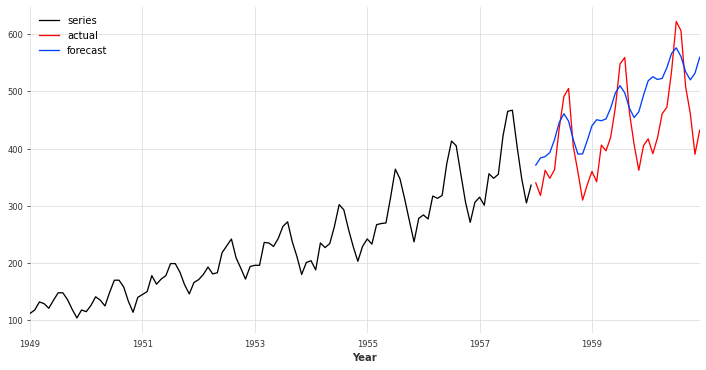

In [8]:
from darts.models import FFT
from darts.metrics import mape
import matplotlib.pyplot as plt


# Polynomial or exponential detrending can be applied.
# Ref: https://github.com/unit8co/darts/blob/master/darts/models/fft.py#L222
model = FFT(trend='poly')
model.fit(train)
pred_val = model.predict(len(val))


# Plotting is done through matplotlib
plt.figure(figsize=(12, 6))
train.plot(label='series')
val.plot(label='actual', color='red')
pred_val.plot(label='forecast')
plt.xlabel('Year')
plt.legend(loc='best')
print("FFT MAPE:", mape(pred_val, val))

### <a name="darts_residual_analysis">Residual Analysis</a>

**Source Code**: [Link](https://github.com/unit8co/darts/blob/master/darts/utils/statistics.py#L308)

`plot_residuals_analysis()` takes as input an univariate time series.

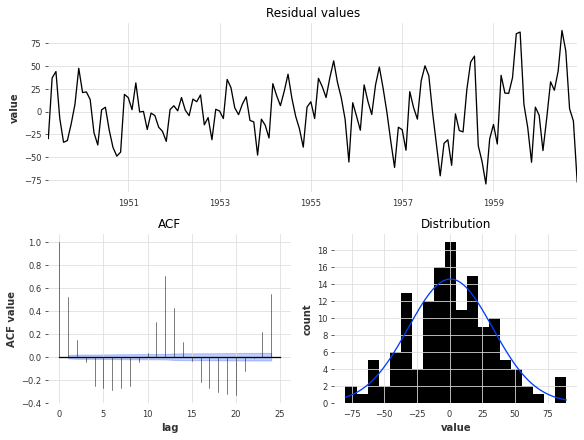

In [11]:
from darts.utils.statistics import plot_residuals_analysis

# Run this cell before plotting residuals
#model_residuals = model.residuals(series_from_dataframe)
plot_residuals_analysis(model_residuals)

### <a name="darts_rnn">4.2 Recurrent Neural Network</a>

**Source Code**: [link](https://github.com/unit8co/darts/blob/master/darts/models/rnn_model.py#L121)

Darts support sklearn scalers to apply to a given time series. Just need to specify the `scaler` parameter of `darts.datapreprocessing.transformers.Scaler`, see code below.

Also, one can pass a custom scaler, but it should implement `fit()` [line 54](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/scaler.py#L54)), `transform()` [line 74](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/scaler.py#L74) and `inverse_transform()` [line 94](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/scaler.py#L94) methods.

In [12]:
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import RobustScaler
from darts.metrics import mape

### <a name="darts_scaler">Scalers</a>

**Source Code**: [link](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/scaler.py#L17)

Darts implements the [Scaler](https://github.com/unit8co/darts/blob/df7287684018372c9a23e3ec66477e22ac543643/darts/dataprocessing/transformers/scaler.py#L14) class, which is a wrapper to scale the time series around the scalers from [sklearn.preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) library. 

In [13]:
# Pass a sklearn scaler
robust_scaler = Scaler(scaler=RobustScaler(quantile_range=(10, 90)))
train_scale_transformed = robust_scaler.fit_transform(train)
val_scale_transformed = robust_scaler.transform(val)
series_scale_transformed = robust_scaler.transform(series_from_dataframe)

Text(0.5, 1.0, 'Robust Scaler applied to data')

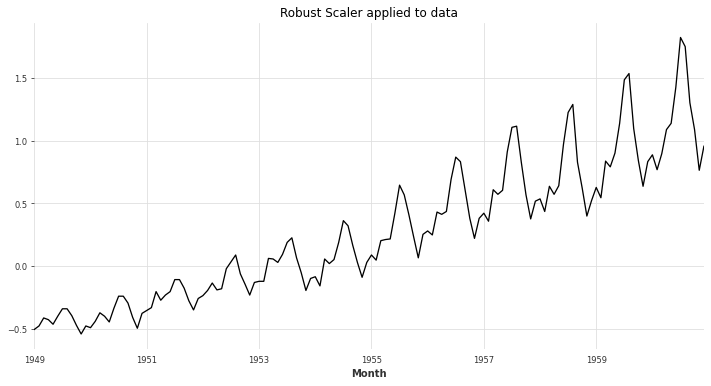

In [15]:
plt.figure(figsize=(12, 6))
series_scale_transformed.plot()
plt.title('Robust Scaler applied to data')

### <a name="darts_transforms">Transforms</a>

Transforms can apply any custom transformation to a time series through a [Mapper](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/mappers.py#L17) or an `InvertibleMapper` if you provided the function transformation and it's inverse.

**Source code**: [link](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/mappers.py#L46)

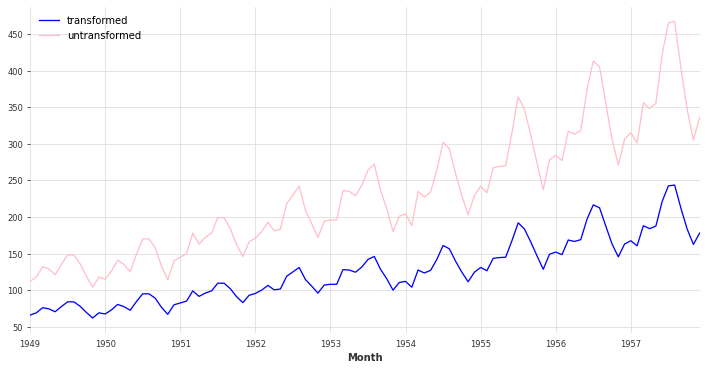

In [16]:
from darts.dataprocessing.transformers import InvertibleMapper
import matplotlib.pyplot as plt

# Dummy transform
invertible_mapper_example = InvertibleMapper(fn=lambda x: (x/2) + 10, inverse_fn=lambda timestamp, x: (x - 10)*2)

# Apply a dummy transform to the train data
train_transformed = invertible_mapper_example.transform(train)

# Dummy transformation
train_untransformed = invertible_mapper_example.inverse_transform(train_transformed)

plt.figure(figsize=(12, 6))
train_transformed.plot(label='transformed', color='blue')
train_untransformed.plot(label='untransformed', color='pink')
plt.legend()

### <a name="darts_missing_values">MissingValuesFiller</a>

`MissingValuesFiller` currently [only](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/transformers/missing_values_filler.py#L35) implement `auto` filler, which is a wrapper of `pandas.DataFrame.interpolate()` method, see [reference](https://github.com/unit8co/darts/blob/master/darts/utils/missing_values.py#L90). Other possibility is [const_fill](https://github.com/unit8co/darts/blob/master/darts/utils/missing_values.py#L68) but it is not applied as `auto` is [returned](https://github.com/unit8co/darts/blob/master/darts/utils/missing_values.py#L61).

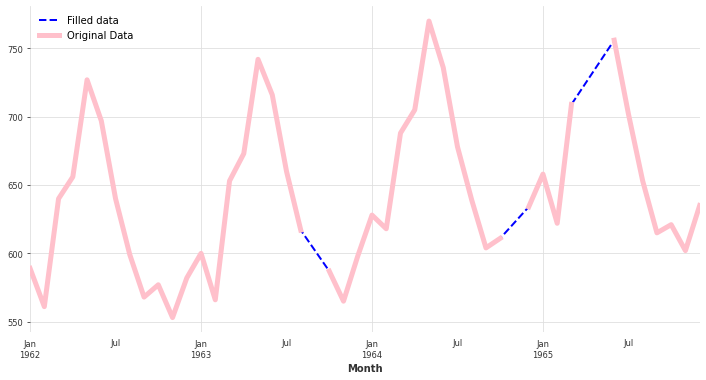

In [17]:
from darts.dataprocessing.transformers import MissingValuesFiller

df_incomplete = pd.read_csv('milk-incomplete.csv')
#df_incomplete.set_index('Month', inplace=True)
incomplete_series = TimeSeries.from_dataframe(df_incomplete, 'Month', ['Pounds per cow'])

# Fill with interpolation
missing_value_filler = MissingValuesFiller()
series_filled = missing_value_filler.transform(incomplete_series)

plt.figure(figsize=(12, 6))

# Filled data
series_filled.plot(label='Filled data', color='blue', linestyle='dashed', linewidth=2)

# Original data
incomplete_series.plot(label='Original Data', color='pink', linewidth=5)

plt.legend()

### <a name="darts_pipeline">Pipeline</a>

**Source code**: [link](https://github.com/unit8co/darts/blob/master/darts/dataprocessing/pipeline.py#L20)

Takes as input a sequence of [data transformers](https://github.com/unit8co/darts/tree/master/darts/dataprocessing/transformers) that is applied sequentially to the data. It applies both a `fit_transform` and `inverse_transform` function.

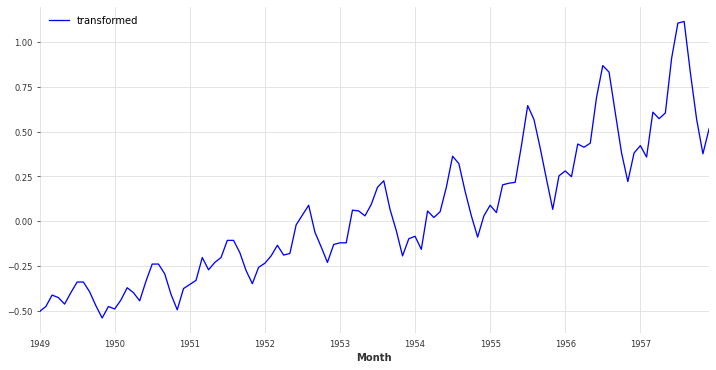

In [18]:
from darts.dataprocessing import Pipeline

pipeline = Pipeline([invertible_mapper_example, robust_scaler])

plt.figure(figsize=(12, 6))

# Apply transform
train_pipeline = pipeline.fit_transform(train)

# Return to original data
#pipeline.inverse_transform(train_pipeline)

train_pipeline.plot(label='transformed', color='blue')
plt.legend()

The `RNNModel` class implements a Vanilla RNN, LSTM and GRU architectures. Some of the advantages of the method are:

* __save the model for later training__. Set `log_tensorboard = True` and passing a `model_name` parameter.

* __Define a custom optimizer___. Set `optimizer_cls` and pass arguments to it through `optimizer_kwargs`.

* __Define a scheduler learning rate__. Set `lr_scheduler_cls` and `lr_scheduler_kwargs`. Read more about the benefits of using a scheduler [here](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/#need-for-learning-rate-schedules)

* __Define a custom loss function__. Set `loss_fn`.

In [19]:
%%time
# Define an LSTM model
darts_rnn = RNNModel(
    model='LSTM',
    output_length=1, # Time steps to predict
    hidden_size=10, # Units in each hidden layer
    n_rnn_layers=3, # Number of Hidden layers 
    input_length=12, # Previous time steps taking into account to forecast
    dropout=0.3, # Dropout percentage
    batch_size=32,
    n_epochs=400,
    optimizer_kwargs={'lr': 0.001}, # Arguments pass to Adam Optimizer
    random_state=42
)

# Train model
darts_rnn.fit(train_scale_transformed, val_training_series=val_scale_transformed, verbose=True)

Training loss: 0.0544, validation loss: 0.1198
CPU times: user 49.9 s, sys: 2.15 s, total: 52 s
Wall time: 49.1 s


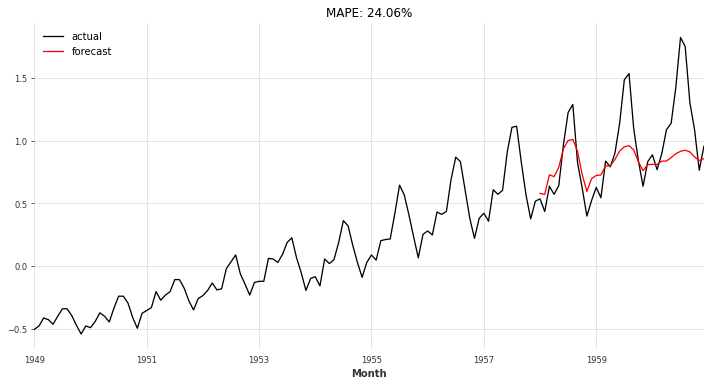

In [21]:
# Predict 26 steps ahead
rnn_pred = darts_rnn.predict(n=36)

plt.figure(figsize=(12, 6))

# Real data
series_scale_transformed.plot(label='actual')

# Pred data
rnn_pred.plot(label='forecast', color='red')
plt.title('MAPE: {:.2f}%'.format(mape(rnn_pred, val_scale_transformed)))
plt.legend()

### <a name="darts_backtesting">Back Testing</a>

Backtesting is used to evaluate the accuracy of a time series model. It takes into account the historical data, splitting it iteratively at given intervals. The following [image](https://www.lokad.com/backtesting-definition#:~:text=In%20the%20context%20of%20time,present%20in%20the%20historical%20data) illustrates it. Sklearn implements splitting the data through the [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) method.

![example_backtesting](figs/backtesting.png)

Darts splits this functionality into two functions:

1. [Historical Forecast](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html?highlight=historical_forecast#darts.models.forecasting_model.ForecastingModel.historical_forecasts)

> Computes the historical forecasts the model would have produced with an expanding training window and (by default) returns a time series created from the last point of each of these individual forecasts.
> To this end, it repeatedly builds a training set from the beginning of training_series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

**Returns** : By default, a single TimeSeries instance created from the last point of each individual forecast. If last_points_only is set to False, a list of the historical forecasts.

2. [Backtest](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html#darts.models.forecasting_model.ForecastingModel.backtest)

> Computes an error score between the historical forecasts the model would have produced with an expanding training window over training_series and the actual series.
> To this end, it repeatedly builds a training set from the beginning of series. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps.

**Returns** : The error score, or the list of individual error scores if reduction is None 

In [22]:
backtest_backtest = darts_rnn.backtest(training_series=series_scale_transformed,
        start=pd.Timestamp('19550101'),
        forecast_horizon=6,
        stride=3,
        reduction=None,
        retrain=False,
        verbose=True
)

print(f'Backtest scores: {backtest_backtest}')


Backtest scores: [30.255169066797844, 22.393778114628383, 33.09405112288584, 28.097850982621054, 13.121532577605086, 9.56013850340322, 9.866872108079642, 17.146168839410393, 14.124516081512983, 10.814572221055407, 10.39620497479979, 14.077585223516712, 17.439735997122256, 17.06822442051078, 27.70732349821263, 24.33262115510647, 12.940428980588466, 20.600935686010104, 19.32038676150682, 14.961434531562368, 24.389912421583716, 34.80788571117475]


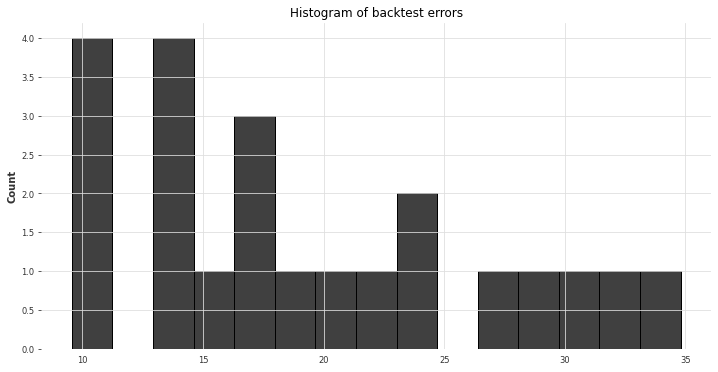

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(backtest_backtest, bins=15)
plt.title("Histogram of backtest errors")
plt.show()

In [24]:
%%time
backtest_historical_forecast = darts_rnn.historical_forecasts(training_series=series_scale_transformed,
                                                start=pd.Timestamp('19550101'), # First point for which prediction is computed
                                                forecast_horizon=6,
                                                stride=3,
                                                retrain=False,
                                                verbose=True)

[2021-01-10 04:56:46,534] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.



CPU times: user 754 ms, sys: 13.4 ms, total: 768 ms
Wall time: 729 ms


[2021-01-10 04:57:40,620] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.


MAPE: 6.11%


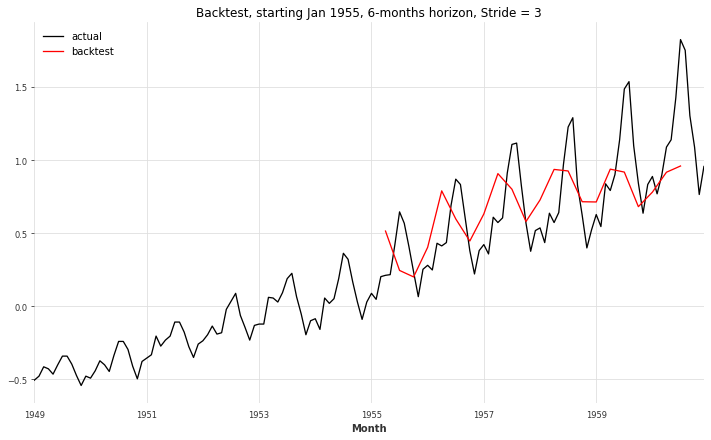

In [27]:
plt.figure(figsize=(12,7))
series_scale_transformed.plot(label='actual')
backtest_historical_forecast.plot(label='backtest', color='red')
plt.legend()
plt.title('Backtest, starting Jan 1955, 6-months horizon, Stride = 3');
print('MAPE: {:.2f}%'.format(mape(robust_scaler.inverse_transform(series_scale_transformed), 
                                  robust_scaler.inverse_transform(backtest_historical_forecast))))

### <a name="darts_gridsearch">Grid Search</a>

**Source Code:** [link](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html?highlight=gridsearch#darts.models.forecasting_model.ForecastingModel.gridsearch)


One can pass not only the parameter defined in the Darts documentation of each model, but also additional parameters that each architecture can define. For example, the docs show us that we can the following arguments to an `RNNModel` class

* model

* input_size 

* output_size 

* output_length 

* hidden_size 

* n_rnn_layers

* hidden_fc_sizes 

* dropout 

* random_state 

but we can also pass parameters that [ForecastingTorchModel](https://github.com/unit8co/darts/blob/df7287684018372c9a23e3ec66477e22ac543643/darts/models/torch_forecasting_model.py#L144) take such as `n_epochs`, `batch_size`, `optimizer` etc.

In [65]:
rnn_gridsearch = {
    'model': ['LSTM', 'RNN', 'GRU'],
    'n_epochs': [200, 400],
    'output_length': [1],
    'hidden_size': [10],
    'n_rnn_layers': [1, 3, 5],
    'input_length': [12],
    'dropout': [0.3, 0.4, 0.5],
    'batch_size': [16, 32, 48, 64]
}

# Instantiate an RNNModel
darts_rnn = RNNModel()

# Set a gridsearch based on rnn_gridsearch
darts_rnn_grid_search = darts_rnn.gridsearch(parameters=rnn_gridsearch,
    forecast_horizon=6,
    training_series=train_transformed,
    verbose=True)

[2021-01-06 05:06:48,881] INFO | darts.models.forecasting_model | Chosen parameters: {'model': 'LSTM', 'n_epochs': 20, 'output_length': 1, 'hidden_size': 10, 'n_rnn_layers': 1, 'input_length': 10}
[2021-01-06 05:06:48,881] INFO | darts.models.forecasting_model | Chosen parameters: {'model': 'LSTM', 'n_epochs': 20, 'output_length': 1, 'hidden_size': 10, 'n_rnn_layers': 1, 'input_length': 10}


### <a name="darts_ensemble_model">4.3 Ensemble Models</a>

**Source Code:** [link](https://github.com/unit8co/darts/blob/master/darts/models/ensemble_model.py#L16)

You can pass a list of forecasting models to ensemble predictions. This models should be an instance of `ForecastingModel` class to be accepted as input.

| Model | Class | Parent Class |
|--------| ------| ------- |
| ARIMA  | UnivariateForecastingModel     |  ForecastingModel|
| AutoARIMA  | UnivariateForecastingModel     |  ForecastingModel|
| ExponentialSmoothing  | UnivariateForecastingModel     |  ForecastingModel|
| FFT  | UnivariateForecastingModel     |  ForecastingModel|
| Prophet  | UnivariateForecastingModel     |  ForecastingModel|
| Theta  | UnivariateForecastingModel     |  ForecastingModel|
|NBEATSModel | TorchForecastingModel| MultivariateForecastingModel |
|RnnModel | TorchForecastingModel| MultivariateForecastingModel |
|TCNModel | TorchForecastingModel| MultivariateForecastingModel |
|TransformerModel | TorchForecastingModel| MultivariateForecastingModel |

In [28]:
from darts.models import (RegressionEnsembleModel,
    ARIMA,
    AutoARIMA,
    Prophet,
    ExponentialSmoothing
)

In [30]:
# Ensemble preds from classical models
ensemble_model = RegressionEnsembleModel(
    forecasting_models=[AutoARIMA(), Prophet(), ExponentialSmoothing()],
    regression_train_n_points=len(train_scale_transformed) - 60,
)

# Fit ensemble model
ensemble_model.fit(train_scale_transformed)

# Forecast 36 points ahead
ensemble_pred = ensemble_model.predict(len(val_scale_transformed))

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

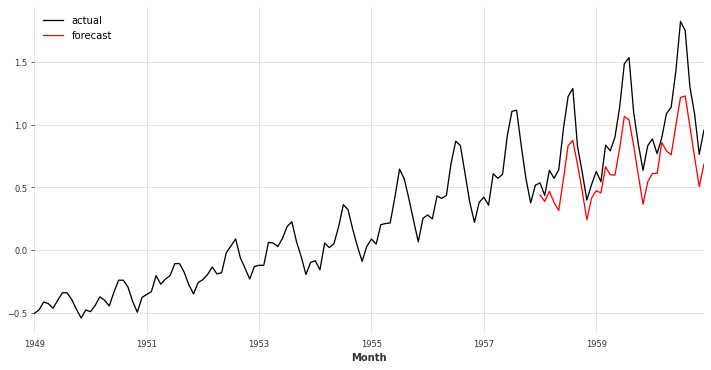

In [31]:
plt.figure(figsize=(12, 6))

# Real data
series_scale_transformed.plot(label='actual')

# Pred data
ensemble_pred.plot(label='forecast', color='red')

plt.legend()

### <a name="darts_conclusion">Conclusion</a>

We list some of the key functionalities of the Darts package:

* Diagnose your series [plotting the autocorrelation](#darts_acf), checking its [seasonality period](#darts_check_seasonality) and decomposing it in [trend and seasonal component](#darts_extract_trend_seasonality).

* Easily remove [trend and seasonality](#darts_remove_trend_seasonality) from time series.

* Apply sequentially transformations ([Fill Missing Value](#darts_missing_values), [Scale](#darts_scaler) and [Transforms](#darts_transforms)) to the time series through a [Pipeline](#darts_pipeline).

* Tune your model through [GridSearch](#darts_gridsearch).

* Evaluate your model through [backtesting](#darts_backtesting) and [residual analysis](#darts_residual_analysis).

* Apply Deep Learning Models (RNN, TCN, N-beats and Transformers).

* Build predictions from an [ensemble](#darts_ensemble_model) of models.